In [62]:
%pip install tabulate

Note: you may need to restart the kernel to use updated packages.


In [63]:
import simpy
import matplotlib.pyplot as plt
from tabulate import tabulate
import numpy as np
from pprint import pprint
from cathousefactory import CatHouseFactory, CatFactoryConfig
from customrng import CustomRNG
from statsprocessing import extract_business_metrics

In [37]:
def run_simulation(config):
    
    rng = CustomRNG(12345)
    env = simpy.Environment()
    factory = CatHouseFactory(env, config, rng)
    
    for i in range(1, 100):
        factory.run(until=i*100000)
    
    return factory.get_stats()

In [38]:
config = CatFactoryConfig()
stats = run_simulation(config)
pprint(extract_business_metrics(stats))

{'cat_approval_rate': 0.6410145241708215,
 'house_success_rate': 0.5973737373737373,
 'houses_per_time': 0.01433498886214511}


In [39]:
PARAM_VARIAIONS = {
    "PLANNED_HOUSES_NUM": [50, 100, 150, 200, 250],
    "CATS_NUM": [2, 4, 6, 8, 10],
    "BUILDERS_NUM": [2, 4, 6, 8, 10],
    "MAX_TEST_TIME": [20, 40, 60, 80, 100]
}

In [45]:
# Анализ чувствительности:

results = dict()
for p, vars in PARAM_VARIAIONS.items():
    print(f"Вариации {p}: {vars}")
    results[p] = []
    for v in vars:
        config = CatFactoryConfig(**{p: v})
        stats = run_simulation(config)
        result = extract_business_metrics(stats)
        results[p].append((v, result))
        print(f"{p}={v}:")
        pprint(result)
        print()

Вариации PLANNED_HOUSES_NUM: [50, 100, 150, 200, 250]
PLANNED_HOUSES_NUM=50:
{'cat_approval_rate': 0.632568306010929,
 'house_success_rate': 0.5846464646464646,
 'houses_per_time': 0.0134692984701595}

PLANNED_HOUSES_NUM=100:
{'cat_approval_rate': 0.6420984175157164,
 'house_success_rate': 0.5983838383838385,
 'houses_per_time': 0.014361525463585871}

PLANNED_HOUSES_NUM=150:
{'cat_approval_rate': 0.6458498593783804,
 'house_success_rate': 0.6030976430976431,
 'houses_per_time': 0.014589289350437792}

PLANNED_HOUSES_NUM=200:
{'cat_approval_rate': 0.6305990286022666,
 'house_success_rate': 0.5901515151515152,
 'houses_per_time': 0.014398781556251364}

PLANNED_HOUSES_NUM=250:
{'cat_approval_rate': 0.6432050342657645,
 'house_success_rate': 0.6029494949494949,
 'houses_per_time': 0.014768477420746726}

Вариации CATS_NUM: [2, 4, 6, 8, 10]
CATS_NUM=2:
{'cat_approval_rate': 0.6416648601777585,
 'house_success_rate': 0.597979797979798,
 'houses_per_time': 0.011837277426191976}

CATS_NUM=4:
{'c

In [61]:
metric_names = set()
for param_data in results.values():
    for _, metrics in param_data:
        metric_names.update(metrics.keys())
metric_names = sorted(metric_names)

statistics = {metric: {'values': []} for metric in metric_names}

for param_data in results.values():
    for _, metrics in param_data:
        for metric in metric_names:
            if metric in metrics:
                statistics[metric]['values'].append(metrics[metric])

for metric in metric_names:
    values = statistics[metric]['values']
    statistics[metric]['mean'] = np.mean(values)
    statistics[metric]['variance'] = np.var(values)
    statistics[metric]['std_dev'] = np.std(values)

table_data = []
for metric in metric_names:
    table_data.append([
        metric,
        statistics[metric]['mean'],
        statistics[metric]['variance'],
        statistics[metric]['std_dev']
    ])

headers = ["Метрика", "Среднее", "Дисперсия", "Стандартное отклонение"]
print(tabulate(table_data, headers=headers, floatfmt=".6f", tablefmt="grid"))

+--------------------+-----------+-------------+--------------------------+
| Метрика            |   Среднее |   Дисперсия |   Стандартное отклонение |
+====================+===========+=============+==========================+
| cat_approval_rate  |  0.629768 |    0.002399 |                 0.048980 |
+--------------------+-----------+-------------+--------------------------+
| house_success_rate |  0.587012 |    0.002091 |                 0.045726 |
+--------------------+-----------+-------------+--------------------------+
| houses_per_time    |  0.014265 |    0.000002 |                 0.001359 |
+--------------------+-----------+-------------+--------------------------+


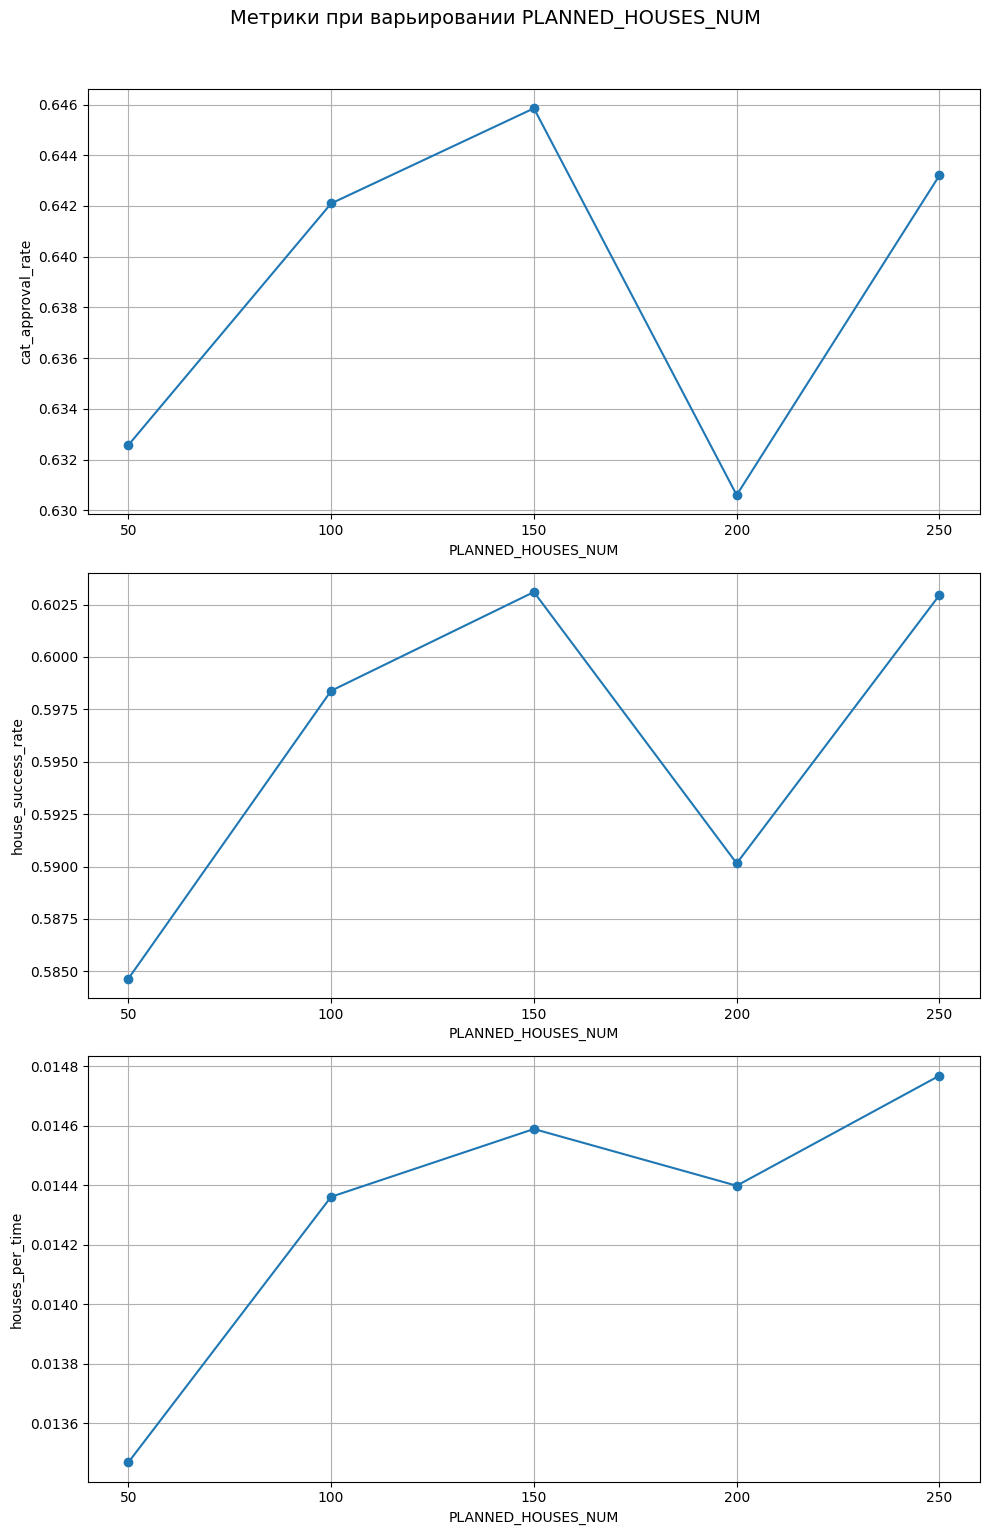

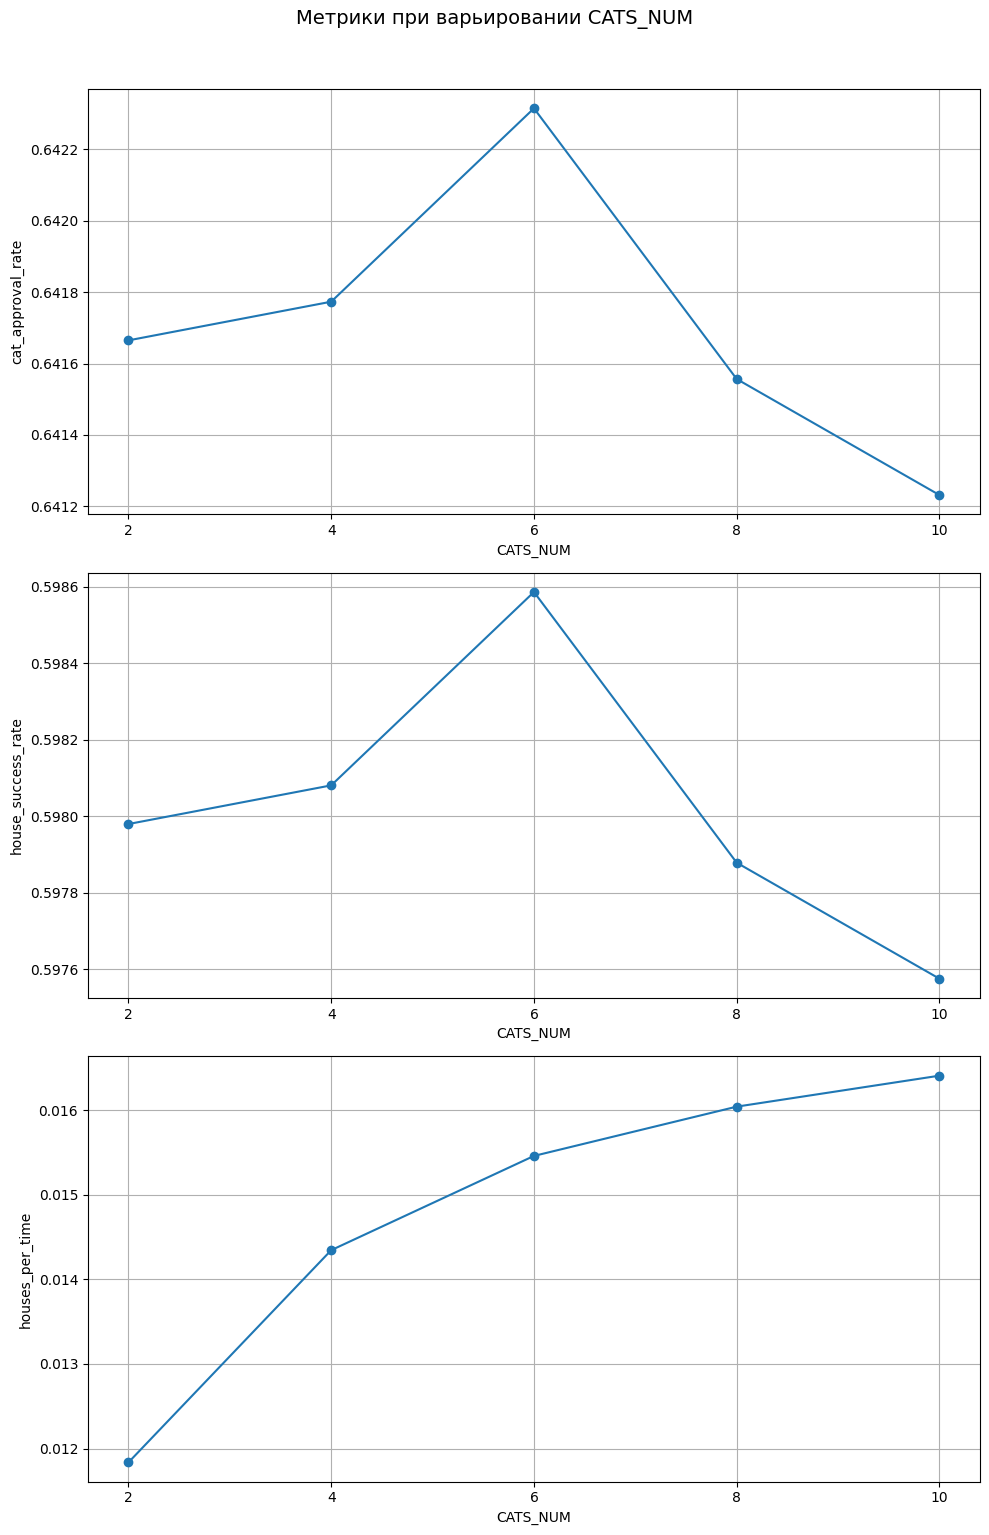

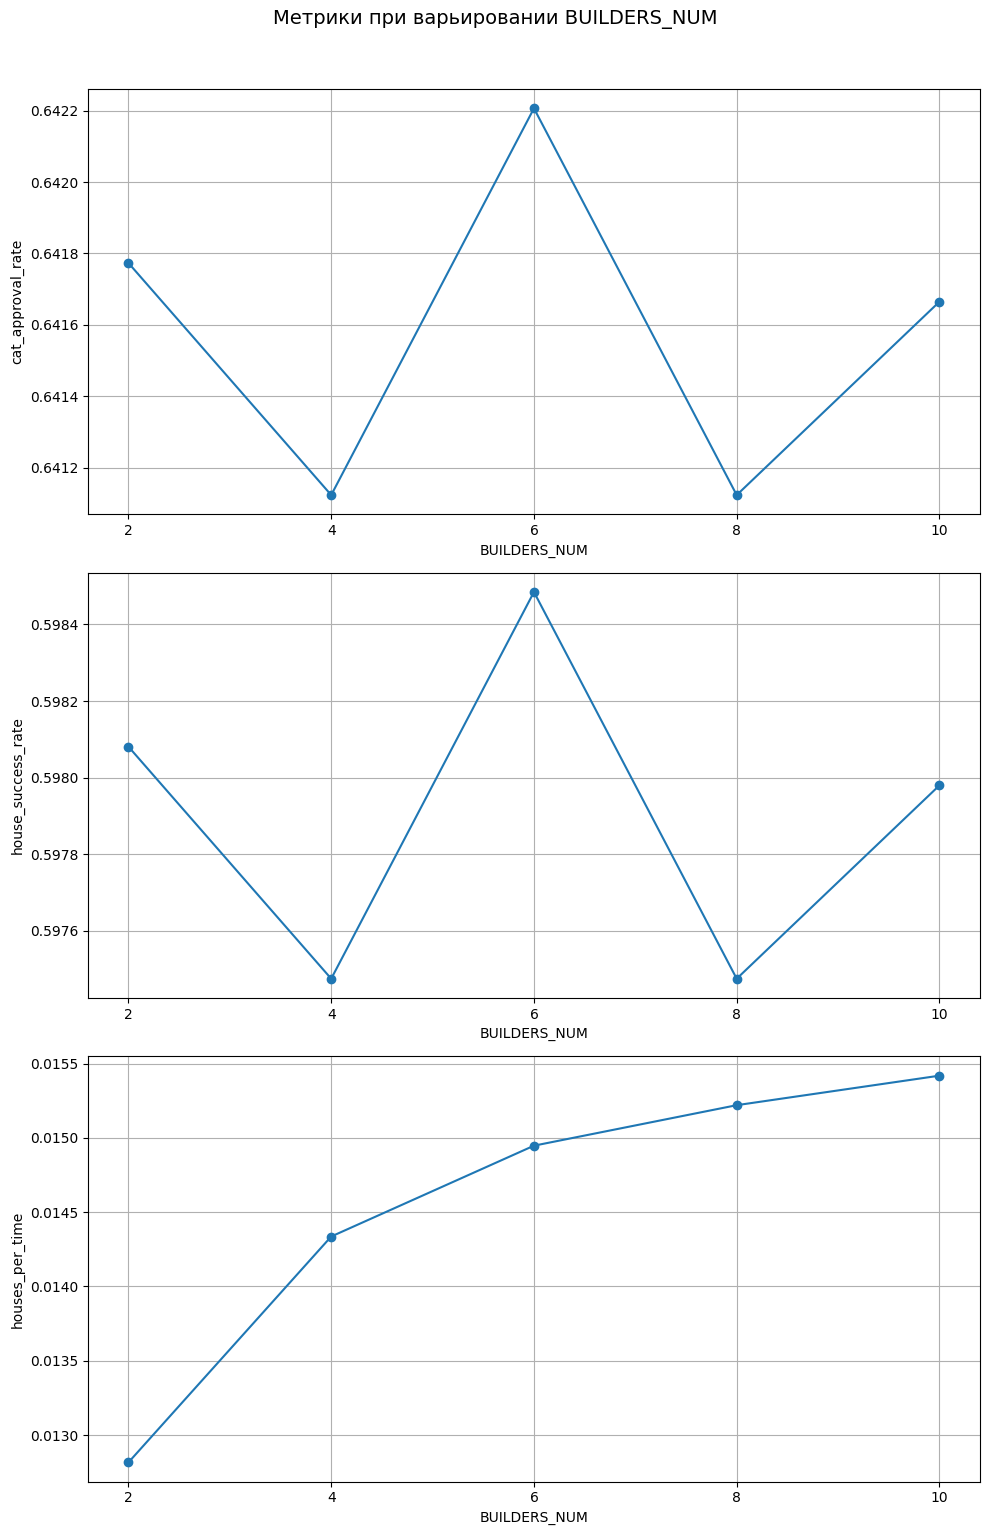

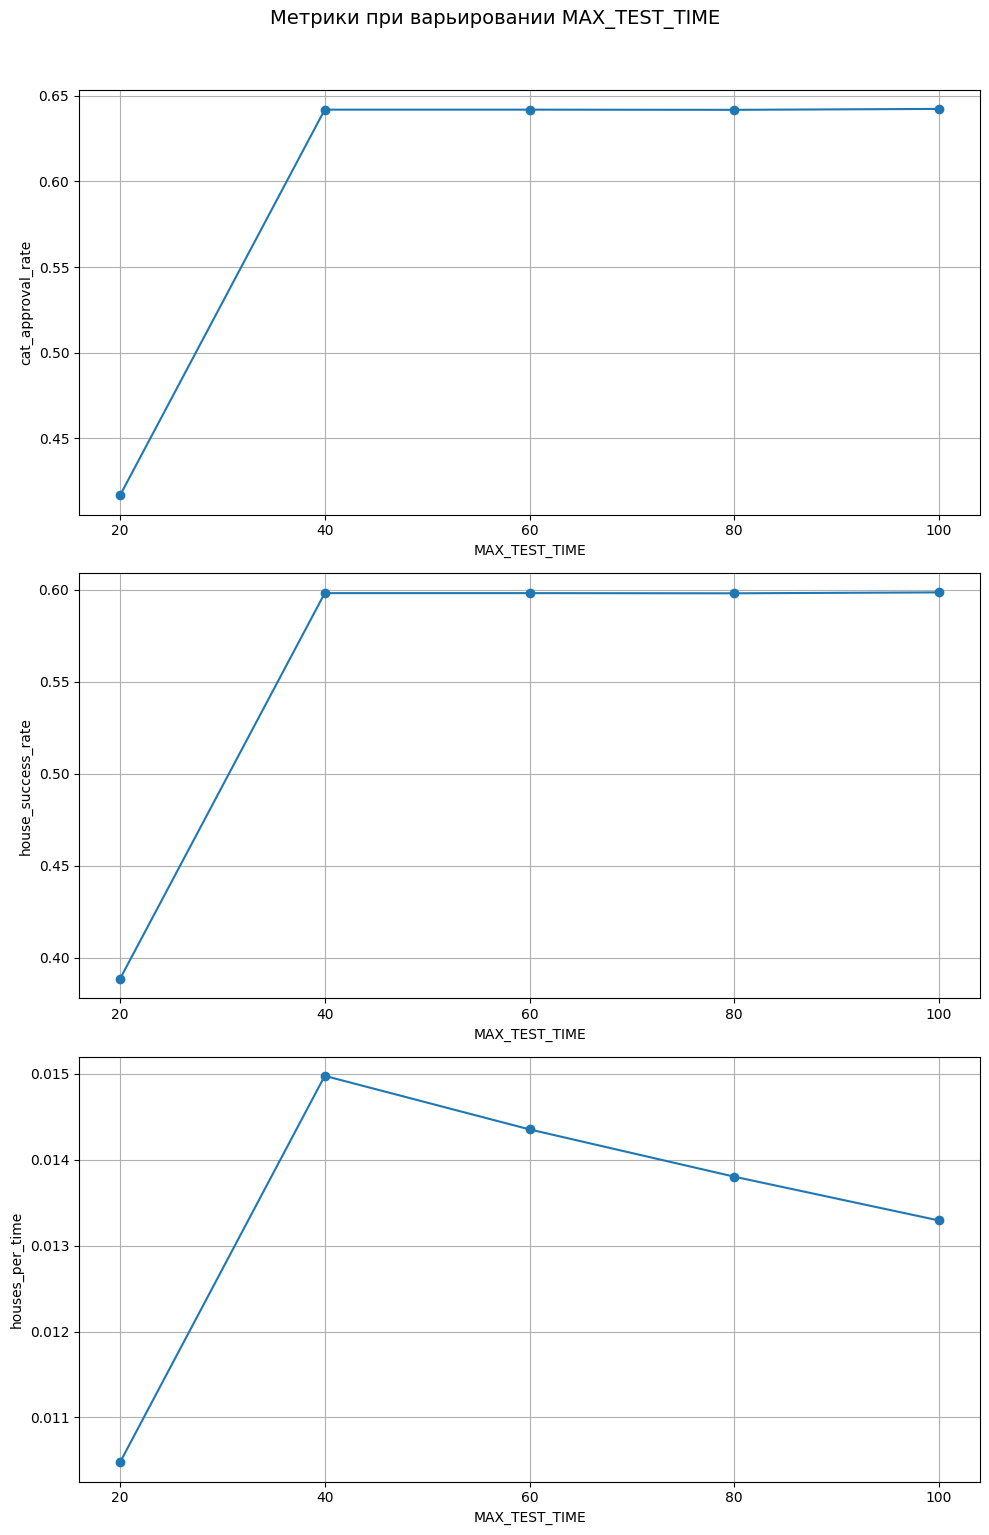

In [64]:
metric_names = set()
for param_data in results.values():
    for _, metrics in param_data:
        metric_names.update(metrics.keys())
metric_names = sorted(metric_names)

for param_name, param_data in results.items():
    if not param_data:
        continue
        
    param_values = [x[0] for x in param_data]
    
    fig, axes = plt.subplots(len(metric_names), 1, figsize=(10, 5 * len(metric_names)))
    fig.suptitle(f'Метрики при варьировании {param_name}', y=1.02, fontsize=14)
    
    if len(metric_names) == 1:
        axes = [axes]
    
    for ax, metric in zip(axes, metric_names):
        metric_values = []
        for _, metrics in param_data:
            metric_values.append(metrics[metric])
        
        ax.plot(param_values, metric_values, 'o-')
        ax.set_xlabel(param_name)
        ax.set_ylabel(metric)
        ax.grid(True)
        
        ax.set_xticks(param_values)
        
    plt.tight_layout()
    plt.show()